In [16]:
import pandas as pd
import numpy as np
import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

We start by loading the data and setting the index column. We then find the number of observations to be 450.

In [17]:
data = pd.read_csv('project1_data.csv', delimiter=';', index_col='id')

In [18]:
data.head()

,weight,height,sex,cats,age,income,savings,single,place,expenses
id,,,,,,,,,,
1,84.99,171.72,1,2,55,1213.10,480.45,0,1,326.33
2,91.06,175.83,1,2,41,1300.14,192.14,0,2,409.24
3,88.30,175.34,1,1,42,1203.19,643.34,0,3,274.26
4,84.51,167.64,1,1,50,1231.13,303.35,0,1,374.86
5,85.72,171.62,1,2,53,892.02,424.99,0,2,248.24


## Task 1

In [19]:
data.describe()

,weight,height,sex,cats,age,income,savings,single,place,expenses
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,89.477667,177.277267,1.488889,2.035556,50.613333,1592.097733,620.030667,0.364444,2.046667,308.810178
std,3.600803,7.918122,0.500433,1.372195,6.847808,940.605357,415.998130,0.481810,0.721944,126.167312
min,77.890000,158.670000,1.000000,0.000000,34.000000,691.730000,85.800000,0.000000,1.000000,-391.650000
25%,86.830000,170.755000,1.000000,1.000000,46.000000,1051.787500,387.605000,0.000000,2.000000,236.567500
50%,89.420000,176.635000,1.000000,2.000000,51.000000,1281.810000,560.415000,0.000000,2.000000,336.990000
75%,92.030000,183.935000,2.000000,3.000000,55.000000,1799.727500,733.565000,1.000000,3.000000,407.227500
max,99.720000,195.790000,2.000000,5.000000,73.000000,7089.020000,3200.920000,1.000000,3.000000,486.790000


We then divide the columns into quantitative and qualitative. The latter ones are sex, single and place. The sex and single columns have two possible values indicating whether a person is a female/lives alone. The place variable describes where the person lives and the values are not indicating anything more than that (the difference of 2 does not mean a place is twice as big).

In [20]:
quantitative_cols = [
    'weight',
    'height',
    'cats',
    'age',
    'income',
    'savings',
    'expenses'
]
qualitative_cols = [
    'sex',
    'single',
    'place'
]

In [7]:
data.isna().sum()

weight      0
height      0
sex         0
cats        0
age         0
income      0
savings     0
single      0
place       0
expenses    0
dtype: int64

We do not have any missing values.

In [21]:
data[quantitative_cols].describe()

,weight,height,cats,age,income,savings,expenses
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,89.477667,177.277267,2.035556,50.613333,1592.097733,620.030667,308.810178
std,3.600803,7.918122,1.372195,6.847808,940.605357,415.998130,126.167312
min,77.890000,158.670000,0.000000,34.000000,691.730000,85.800000,-391.650000
25%,86.830000,170.755000,1.000000,46.000000,1051.787500,387.605000,236.567500
50%,89.420000,176.635000,2.000000,51.000000,1281.810000,560.415000,336.990000
75%,92.030000,183.935000,3.000000,55.000000,1799.727500,733.565000,407.227500
max,99.720000,195.790000,5.000000,73.000000,7089.020000,3200.920000,486.790000


We can see that the values seem to be centered: the Byteland has a very similar population: no weight outside 77-100, no underage people etc. What is concerning is the negative values of expenses. It seems irrational, there is no way one can spend negative amount on food. That would mean one gains money from buying food. So these lines will be deleted. As the number of them is lower than 1%, even if these values are correct, it should not change the results too much.

In [22]:
data[data['expenses'] < 0]

,weight,height,sex,cats,age,income,savings,single,place,expenses
id,,,,,,,,,,
268,93.74,167.67,2,5,41,6671.50,2769.05,1,2,-299.55
342,87.51,168.10,1,3,52,7089.02,3200.92,1,2,-325.31
426,91.21,184.93,2,2,45,6509.39,2602.49,1,2,-349.07
446,86.48,168.03,1,1,59,6838.88,2875.71,1,3,-391.65


In [23]:
data = data[data['expenses'] >= 0]

In [25]:
for col in qualitative_cols:
    display(data[col].value_counts().sort_index())

sex
1    228
2    218
Name: count, dtype: int64

single
0    286
1    160
Name: count, dtype: int64

place
1    107
2    212
3    127
Name: count, dtype: int64

As we can see here, the values here are also not balanced, there are some dominant values. Hovewer, the differences is not big enough to use any augmentation at this point, but it is crucial to keep this in mind while modelling later.

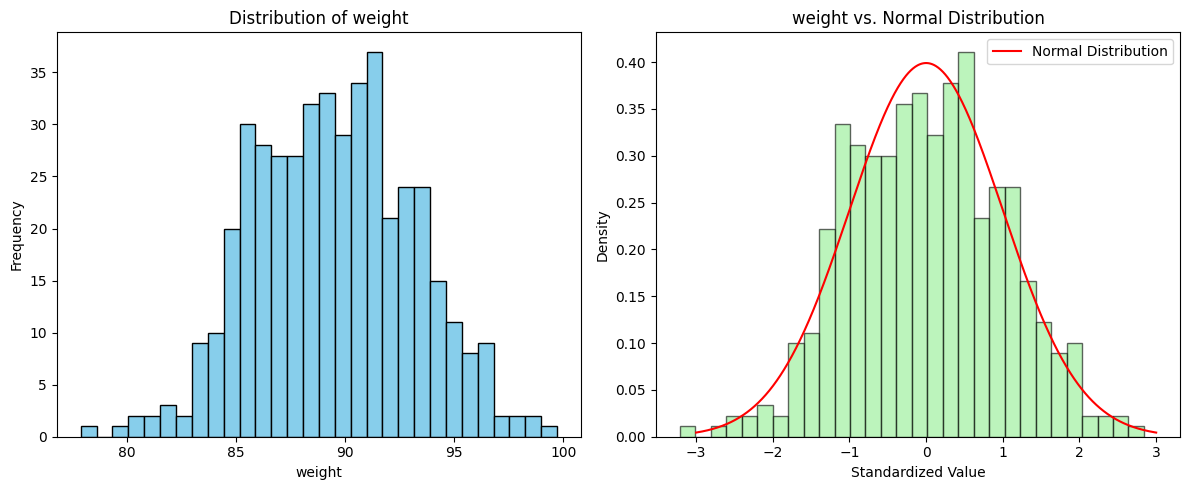

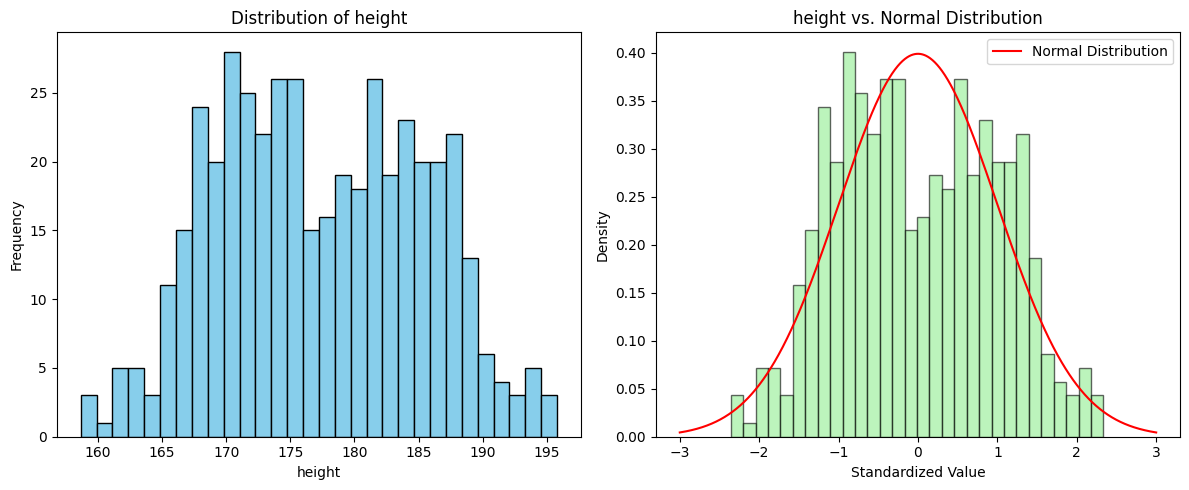

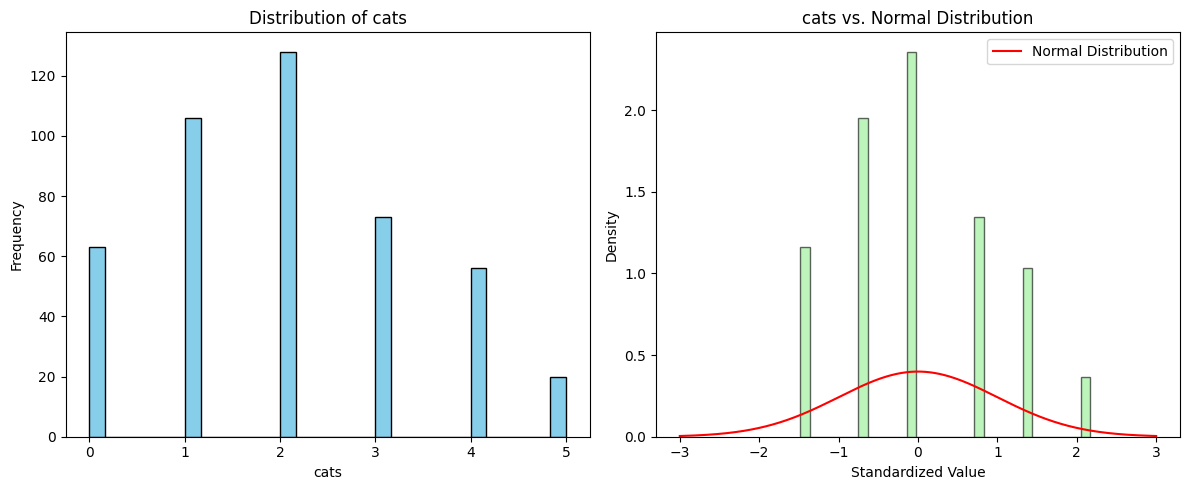

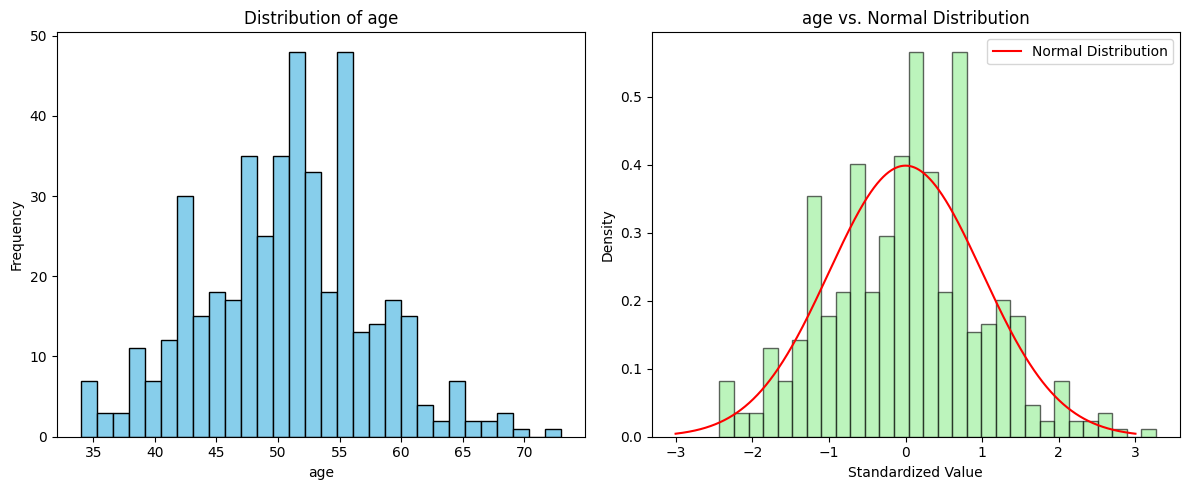

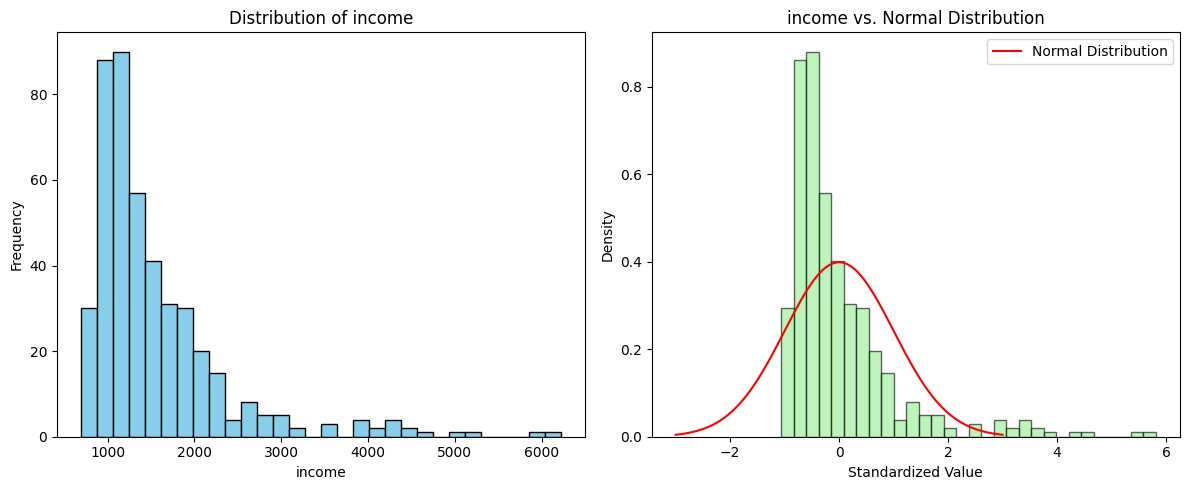

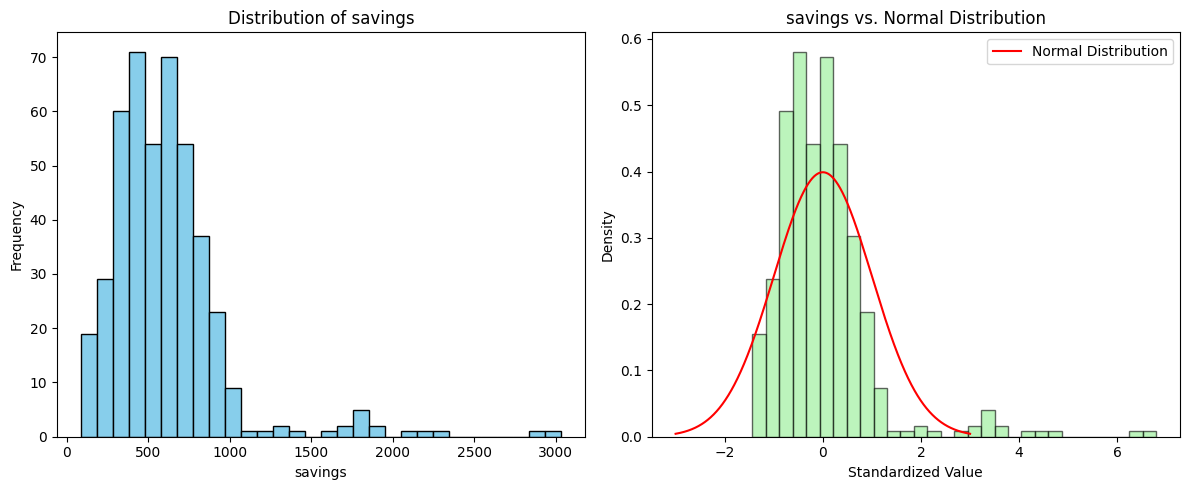

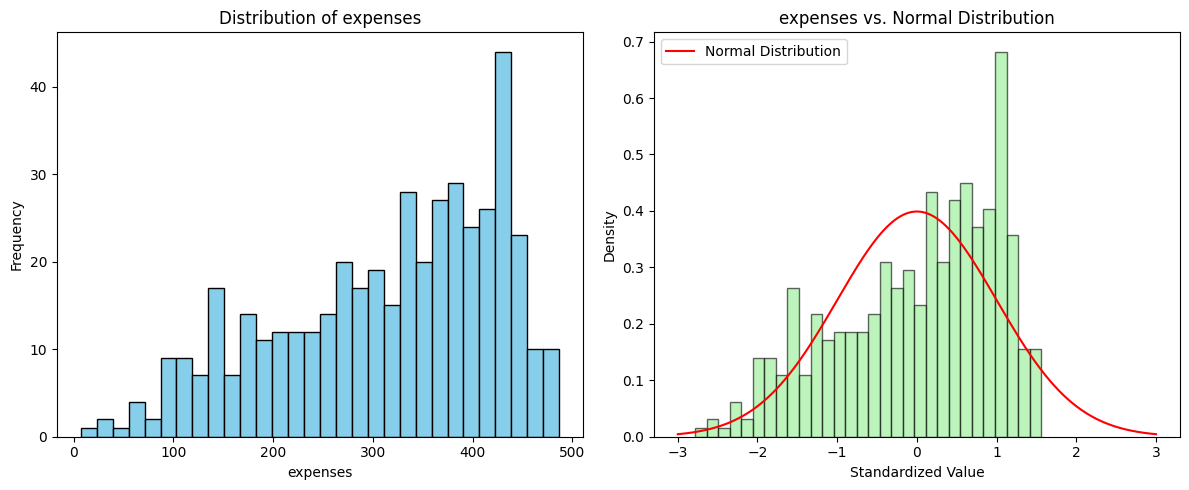

In [27]:
from scipy.stats import norm

for col in quantitative_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))  
    ax[0].hist(data[col], bins=30, color='skyblue', edgecolor='black')
    ax[0].set_title(f'Distribution of {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('Frequency')

    normalized_data = (data[col] - data[col].mean()) / data[col].std()
    ax[1].hist(normalized_data, bins=30, density=True, alpha=0.6, color='lightgreen', edgecolor='black')
    x = np.linspace(-3, 3, 1000)  
    ax[1].plot(x, norm.pdf(x), 'r-', label='Normal Distribution')  
    ax[1].set_title(f'{col} vs. Normal Distribution')
    ax[1].set_xlabel('Standardized Value')
    ax[1].set_ylabel('Density')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [28]:
from scipy.stats import kstest

for col in quantitative_cols:
    standardized_data = (data[col] - data[col].mean()) / data[col].std()
    
    ks_stat, p_value = kstest(standardized_data, 'norm')
    
    print(f"Kolmogorov-Smirnov Test for {col}:")
    print(f"  KS Statistic: {ks_stat:.4f}")
    print(f"  P-value: {p_value:.4e}")
    if p_value < 0.05:
        print("  Result: Reject the null hypothesis (data does not follow a normal distribution)\n")
    else:
        print("  Result: Fail to reject the null hypothesis (data may follow a normal distribution)\n")


Kolmogorov-Smirnov Test for weight:
  KS Statistic: 0.0287
  P-value: 8.4529e-01
  Result: Fail to reject the null hypothesis (data may follow a normal distribution)

Kolmogorov-Smirnov Test for height:
  KS Statistic: 0.0573
  P-value: 1.0304e-01
  Result: Fail to reject the null hypothesis (data may follow a normal distribution)

Kolmogorov-Smirnov Test for cats:
  KS Statistic: 0.1744
  P-value: 2.4612e-12
  Result: Reject the null hypothesis (data does not follow a normal distribution)

Kolmogorov-Smirnov Test for age:
  KS Statistic: 0.0533
  P-value: 1.5323e-01
  Result: Fail to reject the null hypothesis (data may follow a normal distribution)

Kolmogorov-Smirnov Test for income:
  KS Statistic: 0.1712
  P-value: 6.7932e-12
  Result: Reject the null hypothesis (data does not follow a normal distribution)

Kolmogorov-Smirnov Test for savings:
  KS Statistic: 0.1197
  P-value: 4.9879e-06
  Result: Reject the null hypothesis (data does not follow a normal distribution)

Kolmogorov-

As we can see above, although the KS test was able to reject hypothesises about not normal distribution for income, savings and expenses and cats. After some eye-test we can see that weight, height and age are possibly normally distributed.

## Task 2

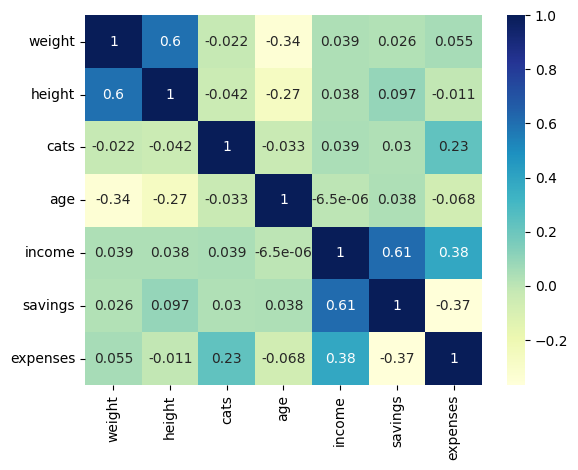

In [29]:
corr = data[quantitative_cols].corr()

dataplot = sns.heatmap(corr, cmap="YlGnBu", annot=True)

In [30]:
from scipy.stats import pearsonr

def test_dependencies(col1, col2, data=data):
    corr, p_value = pearsonr(data[col1], data[col2])
    return p_value


In [31]:
weight_height_dependency = test_dependencies('weight', 'height')
savings_income_dependency = test_dependencies('savings', 'income')
savings_expenses_dependency = test_dependencies('savings', 'expenses')
weight_age_dependency = test_dependencies('weight', 'age')
height_age_dependency = test_dependencies('height', 'age')

weight_height_dependency, savings_income_dependency, savings_expenses_dependency, weight_age_dependency, height_age_dependency

(4.589069844029187e-44,
 2.26753563873923e-47,
 1.2775371046733057e-15,
 1.274816656342384e-13,
 7.608694900045079e-09)

We can see from the above results that some variables are correlated. For weight and height or for savings and income/expenses it is obvious, this is based in economics theory. What is more interesting is the relation between age and weight. The younger you are the more you weight it seems. All the relations are statistically important after testing (p-values smaller than 0.05).

## Task 3

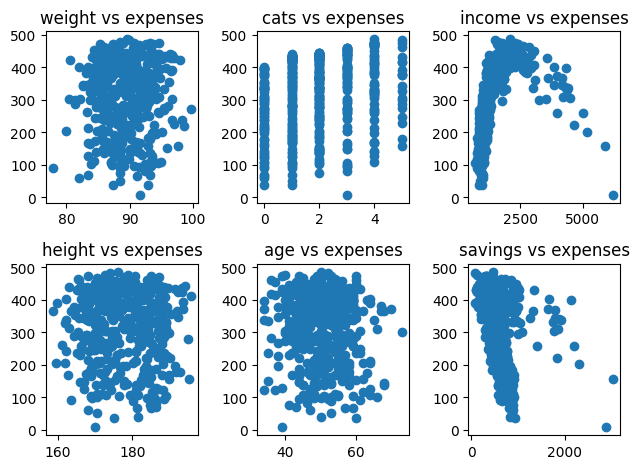

In [32]:
fig, ax = plt.subplots(2, 3)
i = 0
j = 0
for col in quantitative_cols:
    if col != 'expenses':
        ax[i, j].scatter(data[col], data['expenses'])
        ax[i, j].set_title(col+' vs expenses')
        i += 1
        if i > 1:
            i = 0
            j += 1

plt.tight_layout()

We can see no easy to detect relation betweem weight, height and age and expenses. What is clear is the fact that the more cats you have the more you spend. The relation between income and expenses seem to be non-linear. THere is a maximum point in the middle. With savings, the relation is there, but the form is a little complicated.

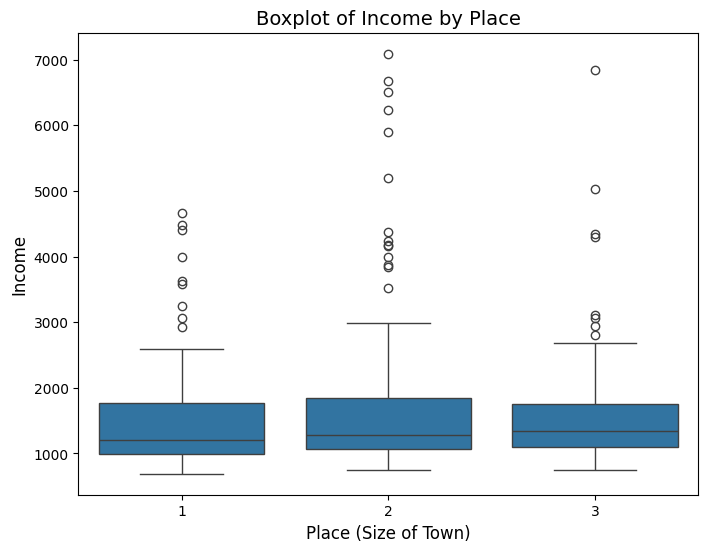

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='place', y='income')
plt.title('Boxplot of Income by Place', fontsize=14)
plt.xlabel('Place (Size of Town)', fontsize=12)
plt.ylabel('Income', fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['1', '2', '3'])
plt.show()

This is a really fascinating graph, it seems that the Byteland has no issues with unbalanced income depending on the place you live. As we can see, almost all of the boxplots are the same or are very similar at least. On top of that, as the theory may suggest, teh only outliers are positive and are the most common for average sized cities. It is contrary to the situation in our world.

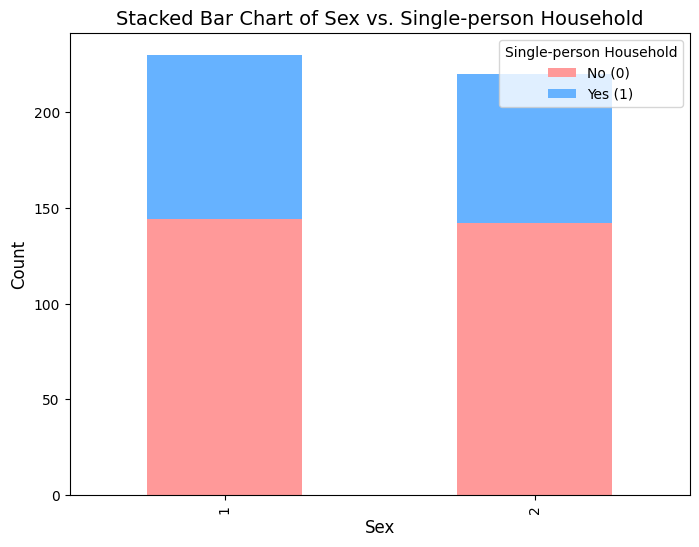

In [17]:
crosstab = pd.crosstab(data['sex'], data['single'])

crosstab.plot(kind='bar', stacked=True, color=['#FF9999', '#66B2FF'], figsize=(8, 6))
plt.title('Stacked Bar Chart of Sex vs. Single-person Household', fontsize=14)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Single-person Household', labels=['No (0)', 'Yes (1)'])
plt.show()

As we can see there are no huge differences in how the people live depending on the sex, both males and females live single similar percentage of time.

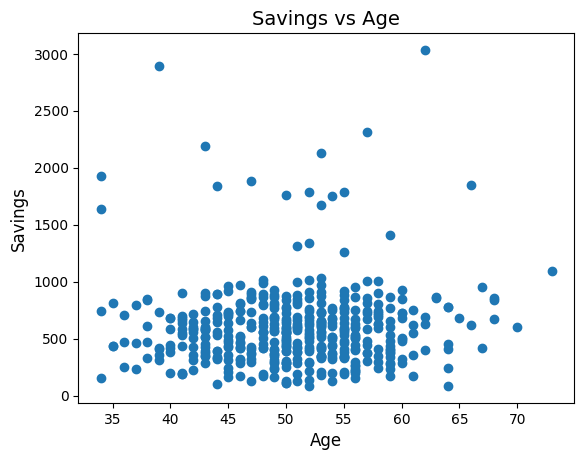

In [34]:
plt.scatter(data['age'], data['savings']);
plt.title('Savings vs Age', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Savings', fontsize=12)
plt.show()

As we can see, the Byteland has no issue with saving money in the youngest age group (although it has to be said that there is no one younger than 35 years). Contrary to our world, the savings seem to be equally distributed, no matter of the age group.

## Task 4

In [35]:
data['wealth_class'] = 0
data.loc[data['income'] > data.income.quantile(0.25), 'wealth_class'] = 1
data.loc[data['income'] > data.income.quantile(0.75), 'wealth_class'] = 2
data.loc[data['income'] > data.income.quantile(0.9), 'wealth_class'] = 3

In [36]:
result = data.groupby('wealth_class')[['expenses']].agg([
    'mean',
    'std',
    ('q25', lambda x: np.percentile(x, 25)),
    ('q50', lambda x: np.percentile(x, 50)),
    ('q75', lambda x: np.percentile(x, 75)),
    'count',
])

result

expenses                                             
                    mean        std      q25      q50       q75 count
wealth_class                                                         
0             180.824107  73.058353  123.840  169.565  238.3925   112
1             339.536396  78.711063  288.665  351.720  395.2400   222
2             422.188507  35.302295  406.665  431.580  441.2150    67
3             364.758889  90.626161  335.630  392.010  425.2900    45

We can see what seems to contradictory to common sense: that at some point of income, people stop spending money on food. The wealthiest group spend much less than two poorer ones. What is logical is the variance in this group, many outliers expenses. Interestingly, the lowest variance is not for the porrest but for the well-positioned.

## Task 5

### a

In [20]:
women_savings = data.loc[data['sex']==1, 'savings']
men_savings = data.loc[data['sex']==2, 'savings']

import scipy.stats as stats

t_stat, p_value = stats.ttest_ind(women_savings, men_savings, equal_var=False, alternative='less') #H_0 women save more

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -0.6502094472378092
P-value: 0.2579451345652113


There is no evidence to reject the null hypothesis that women earn more.

### b

In [21]:
data['expense_div_income'] = data['expenses'] / data['income']

model = sm.OLS(data['savings'], sm.add_constant(data[['expense_div_income']]))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                savings   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     654.7
Date:                Sat, 07 Dec 2024   Prob (F-statistic):           1.17e-89
Time:                        11:07:50   Log-Likelihood:                -3149.2
No. Observations:                 450   AIC:                             6302.
Df Residuals:                     448   BIC:                             6311.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1585.2216     39.744     39.886      0.000    1507.113    1663.330
expense_div_income -4447.1743    173.810    -25.586      0.000   -4788.758   -4105.591
==============================================================================
Omnibus:                      159.267   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              892.681
Skew:                           1.420   Prob(JB):                    1.43e-194
Kurtosis:                       9.289   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As the value of coef is negative and the t-test seems to suggest that this variable is important, we can say that this hypothesis cannot be rejected.

### c

In [22]:
from scipy.stats import ttest_1samp

women_weights = data.loc[data['sex']==1, 'weight']

t_stat, p_value = ttest_1samp(women_weights, popmean=56, alternative='greater')

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 181.9430403811302
P-value: 5.690297645681283e-250


We have to reject the null hypothesis that the mean value is smaller than 56, which means, that the mean weight is bigger.

### d

We test whether wight is a normal distribution with mean 89.5 and std 3.6

In [42]:
from scipy.stats import chisquare, norm

weights = data['weight']

mean_weight = 89.5
std_weight = 3.6

num_bins = 10
bin_edges = np.linspace(weights.min(), weights.max(), num_bins + 1)

observed_freq, _ = np.histogram(weights, bins=bin_edges)

cdf_values = norm.cdf(bin_edges, loc=mean_weight, scale=std_weight)
expected_prob = np.diff(cdf_values) 
expected_freq = expected_prob * len(weights)

expected_freq *= observed_freq.sum() / expected_freq.sum()

chi_square_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)

print("Chi-Square Statistic:", chi_square_stat)
print("p-value:", p_value)

Chi-Square Statistic: 9.404624703945819
p-value: 0.40079243138163523


As we can see the p-value is higher than 0.05, so we cannot reject the null hypothesis of normal distribution with these parameters.

## Task 6

We start by creating dummy columns from qualitative columns.

In [44]:
dummies = pd.get_dummies(data['place'], drop_first=True) * 1
dummies.columns = ['place_' + str(col) for col in dummies.columns]

df = data.drop(['place', 'wealth_class', 'expense_div_income'], axis=1).join(dummies)

KeyError: "['expense_div_income'] not found in axis"

We now use the basic model with all variables.

In [43]:
y = df['expenses']
X = df.drop('expenses', axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()


NameError: name 'df' is not defined

Now we use tests similar to the ones from lab 7 for diagnostics.

In [26]:
X_np = np.asarray(X)
y_np = np.asarray(y)

model = sm.OLS(y_np, X_np)
results = model.fit()
sm.stats.diagnostic.linear_reset(results, power=2, test_type='fitted')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=68.14635937637051, p-value=1.517994810558416e-16, df_denom=1>

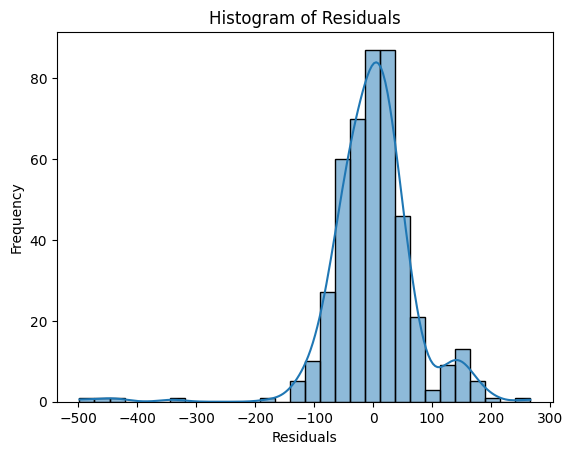

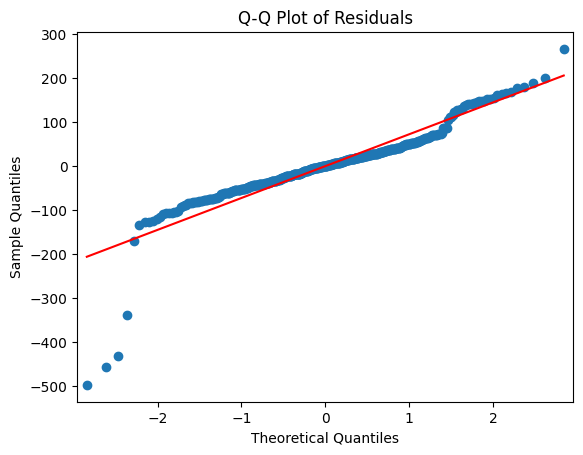

Shapiro-Wilk Test Statistic: 0.859787004381873, p-value: 1.2057498059179103e-19
Residuals do not appear to follow a normal distribution (reject H0).


In [27]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

# Plot Histogram of Residuals
resids = results.resid
sns.histplot(resids, kde=True, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Q-Q Plot
qqplot(resids, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

# Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(resids)
print(f"Shapiro-Wilk Test Statistic: {shapiro_stat}, p-value: {shapiro_p}")

# Conclusion
if shapiro_p > 0.05:
    print("Residuals appear to follow a normal distribution (fail to reject H0).")
else:
    print("Residuals do not appear to follow a normal distribution (reject H0).")


<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\unoci\AppData\Local\Temp\ipykernel_3596\4078273969.py:20: SyntaxWarning: invalid escape sequence '\s'
  plot_lm_2.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');


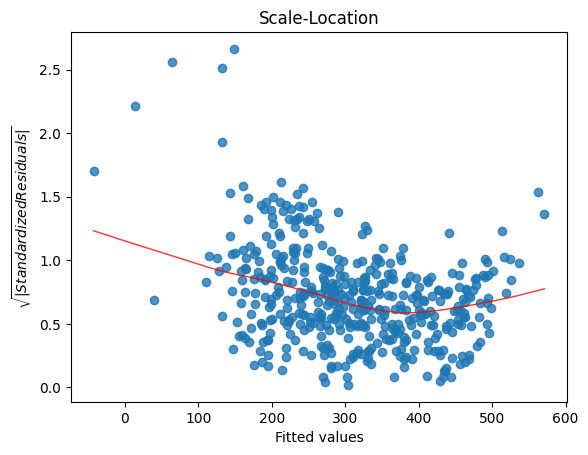

In [28]:
from statsmodels.graphics.gofplots import ProbPlot

model_fitted_y = results.fittedvalues
model_residuals = results.resid
model_norm_residuals = results.get_influence().resid_studentized_internal
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

plot_lm_2 = plt.figure()
sns.regplot(x=model_fitted_y, y=model_norm_residuals_abs_sqrt,
            scatter=True,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_2.axes[0].set_title('Scale-Location')
plot_lm_2.axes[0].set_xlabel('Fitted values')
plot_lm_2.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

#calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

    feature          VIF
0     const  2187.516701
1    weight     1.978396
2    height     2.787977
3       sex     3.254002
4      cats     1.012013
5       age     1.156301
6    income     5.663402
7   savings     3.464390
8    single     2.761475
9   place_2     1.597357
10  place_3     1.592299


The model is terrible to say the least. It has all possible issues: no lienar form, heteroscedascity, not normally distributed residuals.

We start  the model from scratches as the model above has all the issues, many variables are not important. The first idea is to create a new key variable: disposable income as the difference between the income and savings. The logic behind it is that the expenses are a percent of money we get for a month after putting some of the income for the future. 

In [ ]:
df['const'] = 1

In [1]:
df['disposable_income'] = df['income'] - df['savings']

plt.scatter(df['disposable_income'], df['expenses'])

NameError: name 'df' is not defined

It is clear that there is a relation between this new variable and expenses. However it is not linear. We can see a parabola in the picture, so we will use square of disposable income too for our model.

In [ ]:
df['disposable_income_2'] = (df['income'] - df['savings']) ** 2

In [ ]:
columns = [
    'const', 
    'disposable_income',
    'disposable_income_2',
]

In [ ]:
y = df['expenses']
X = df[columns]

model = sm.OLS(y, X)
results = model.fit()

results.summary()

In [ ]:
X_np = np.asarray(X)
y_np = np.asarray(y)

model = sm.OLS(y_np, X_np)
results = model.fit()
sm.stats.diagnostic.linear_reset(results, power=2, test_type='fitted')

In [ ]:
df['resid'] = model.resid

In [ ]:
df.groupby('place')['resid'].agg(lambda x: abs(x).mean())

In [ ]:
df.groupby('single')['resid'].agg(lambda x: abs(x).mean())

In [ ]:
df.groupby('cats')['resid'].agg(lambda x: abs(x).mean())

Model still doesn't work. We will check which variable can help. Grouping by qualitative variables allow to check their significance. We can see that the number of cats is important. So we add it to our model, but as we can see the relation is not linear, so we create dummies for each possible number of cats.

In [34]:
dummies = pd.get_dummies(df['cats']) * 1
dummies.columns = [str(col) + '_cats' for col in dummies.columns]
dummies.head()
df = df.join(dummies)

In [ ]:
columns = [
    'const', 
    'disposable_income',
    'disposable_income_2',
    '1_cats',
    '2_cats',
    '3_cats',
    '4_cats',
    '5_cats'
]


In [80]:
y = df['expenses']
X = df[columns]

model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               expenses   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.044e+05
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:05:52   Log-Likelihood:                -1147.4
No. Observations:                 450   AIC:                             2311.
Df Residuals:                     442   BIC:                             2344.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.9402      0.498     21.978      0.000       9.962      11.919
disposable_income       0.4844      0.001    835.959      0.000       0.483       0.486
disposable_income_2    -0.0002   1.92e-07   -784.153      0.000      -0.000      -0.000
1_cats                 34.7407      0.497     69.922      0.000      33.764      35.717
2_cats                 40.2348      0.481     83.592      0.000      39.289      41.181
3_cats                 56.7311      0.538    105.529      0.000      55.675      57.788
4_cats                 84.0079      0.574    146.229      0.000      82.879      85.137
5_cats                 88.0627      0.790    111.539      0.000      86.511      89.614
==============================================================================
Omnibus:                        1.050   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.592   Jarque-Bera (JB):                1.151
Skew:                           0.098   Prob(JB):                        0.562
Kurtosis:                       2.849   Cond. No.                     1.85e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [81]:
X_np = np.asarray(X)
y_np = np.asarray(y)

model = sm.OLS(y_np, X_np)
results = model.fit()
sm.stats.diagnostic.linear_reset(results, power=2, test_type='fitted')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=1.6704950921790758, p-value=0.19619223407471387, df_denom=1>

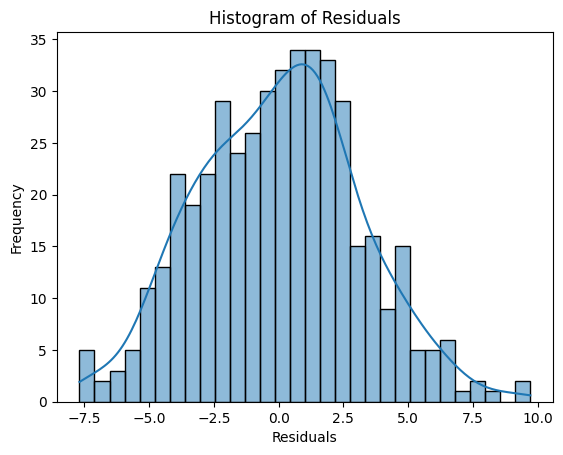

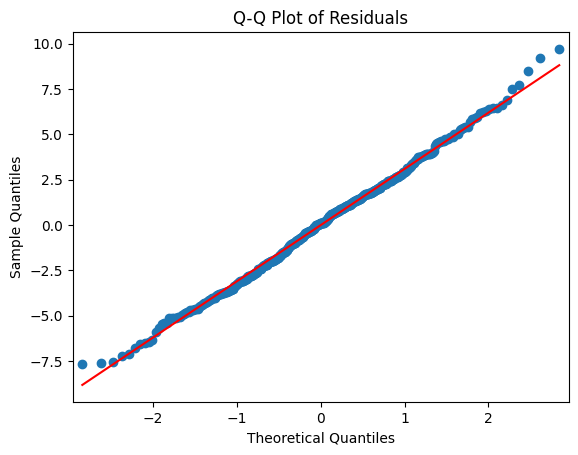

Shapiro-Wilk Test Statistic: 0.9964908363870816, p-value: 0.4324571763750744
Residuals appear to follow a normal distribution (fail to reject H0).


In [82]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

# Plot Histogram of Residuals
resids = results.resid
sns.histplot(resids, kde=True, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Q-Q Plot
qqplot(resids, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

# Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(resids)
print(f"Shapiro-Wilk Test Statistic: {shapiro_stat}, p-value: {shapiro_p}")

# Conclusion
if shapiro_p > 0.05:
    print("Residuals appear to follow a normal distribution (fail to reject H0).")
else:
    print("Residuals do not appear to follow a normal distribution (reject H0).")


<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\unoci\AppData\Local\Temp\ipykernel_3596\4078273969.py:20: SyntaxWarning: invalid escape sequence '\s'
  plot_lm_2.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');


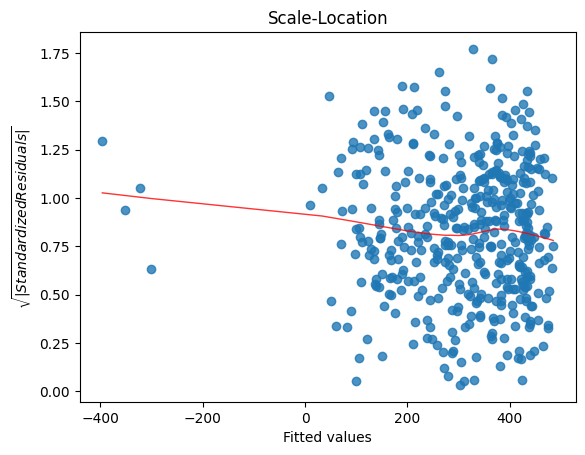

In [83]:
from statsmodels.graphics.gofplots import ProbPlot

# model values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid
# normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

plot_lm_2 = plt.figure()
sns.regplot(x=model_fitted_y, y=model_norm_residuals_abs_sqrt,
            scatter=True,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_2.axes[0].set_title('Scale-Location')
plot_lm_2.axes[0].set_xlabel('Fitted values')
plot_lm_2.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

In [84]:
from statsmodels.stats.diagnostic import het_breuschpagan

_, p_value, _, _ = het_breuschpagan(results.resid, results.model.exog)

In [85]:
p_value

np.float64(0.9209187528383264)

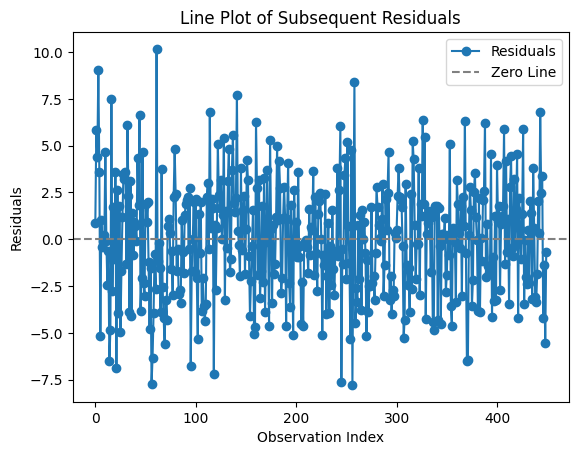

In [67]:
# put your code here
import matplotlib.pyplot as plt

# Assuming `results` contains the fitted regression model
residuals = results.resid  # Extract residuals

# Line plot of subsequent residuals
plt.plot(residuals, marker='o', linestyle='-', label='Residuals')
plt.axhline(y=0, color='gray', linestyle='--', label='Zero Line')
plt.title("Line Plot of Subsequent Residuals")
plt.xlabel("Observation Index")
plt.ylabel("Residuals")
plt.legend()
plt.show()



Now the model is almost perfect. The R^2 is 0.999 which cannot be beaten. On top of that, after testing, we can see that the model is in correct form(RESET test, the residuals are nomally distributed (qq-plot) and there is no sign of heteroscedascity (we used Breusch-Pagan test plus some visualizations)).